In [ ]:
#Importation des bibliothèques

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_score
from sklearn.metrics import roc_curve, roc_auc_score,auc, confusion_matrix
import xgboost as xgb

In [4]:
data_test=pd.read_csv("data/test.csv")
data_train=pd.read_csv("data/train.csv")

In [5]:
X_test = data_test.copy()

In [ ]:
#Base de données train a 15000
data_test.shape


(10000, 13)

In [11]:
data_train.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [12]:
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard','IsActiveMember', 'EstimatedSalary', 'Exited']

In [13]:
data_train.dtypes

id                   int64
CustomerId         float64
Surname             object
CreditScore        float64
Geography           object
Gender              object
Age                float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited             float64
dtype: object

In [14]:
columns_of_interest = ['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Age']

# Get unique values for each specified column
for column in columns_of_interest:
    unique_values = data_train[column].unique()
    print(f"Unique values in '{column}': {unique_values}")

Unique values in 'Tenure': [ 7. 10.  8.  9.  3.  6.  0.  5.  1.  4.  2.]
Unique values in 'NumOfProducts': [2. 1. 3. 4. 6.]
Unique values in 'HasCrCard': [1. 0.]
Unique values in 'IsActiveMember': [1. 0.]
Unique values in 'Age': [49. 30. 32. 39. 45. 33. 40. 53. 34. 46. 38. 47. 50. 35. 31. 43. 29. 42.
 37. 27. 51. 21. 36. 28. 26. 59. 48. 25. 55. 64. 20. 56. 41. 52. 44. 62.
 57. 23. 61. 58. 54. 22. 63. 24. 60. 18. 71. 19. 66. 69. 67. 65. 70. 68.
 72.]


In [15]:
#Enlever les variables qui ne sont pas nécessaires
data_train = data_train.drop(columns=["id","CustomerId", "Surname"])


In [16]:
X_test = X_test.drop(columns=["id","CustomerId", "Surname"])

CreditScore          0.0
Age                  0.0
Tenure               0.0
Balance              0.0
NumOfProducts        0.0
HasCrCard            0.0
IsActiveMember       0.0
EstimatedSalary      0.0
Geography_Germany    0.0
Geography_Spain      0.0
Gender_Male          0.0
dtype: float64

# Correlation

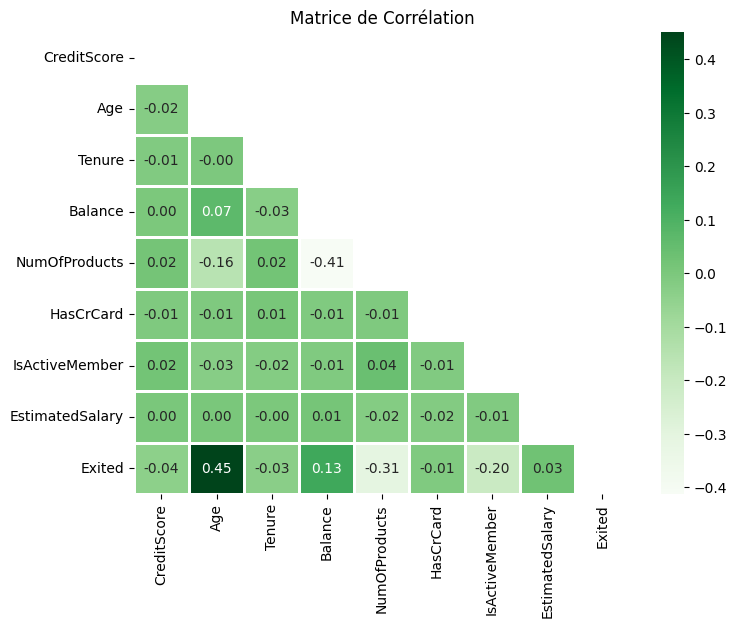

In [17]:
corr_matrix = data_train[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='Greens',linewidths=1,mask=np.triu(corr_matrix),fmt = '.2f', annot=True)
plt.title('Matrice de Corrélation')
plt.show()

In [18]:
# les variables les plus corrélées avec une variable cible
top_corr_with_target = corr_matrix["Exited"].sort_values(ascending=False)
top_corr_with_target= pd.DataFrame(top_corr_with_target)
top_corr_with_target[1:]

,Exited
Age,0.451071
Balance,0.134866
EstimatedSalary,0.026222
HasCrCard,-0.009505
Tenure,-0.031413
CreditScore,-0.041291
IsActiveMember,-0.204799
NumOfProducts,-0.306696


# Doublons

In [19]:
# Vérifier s'il y a des doublons
doublons = data_train.duplicated()
nb_doublons = doublons.sum()
print(f"Nombre de doublons : {nb_doublons}")

Nombre de doublons : 0


# NA

In [20]:
has_na = data_train.isna().any().any()
print("Any NA values in the dataset:", has_na)

Any NA values in the dataset: False


Nous divisons notre base de données en ensembles d'entraînement (train) et de test avant de réaliser toutes les manipulations, afin d'éviter de biaiser les résultats sur l'ensemble de test.
(page 274 cours ML: Model Selection (hold out a validation set))

In [21]:
train_selection, test_selection = train_test_split(data_train, test_size=0.2, random_state=0)

# Outliers

In [22]:
#¨Pour set d'apprentissage
for col in numeric_cols:

    Q1 = train_selection[col].quantile(0.25)
    Q3 = train_selection[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    number_outliers = train_selection[(train_selection[col] < lower_bound) | (train_selection[col] > upper_bound)].shape[0]

    print("Le nombre des outliers de la variable", col, "est", number_outliers)


Le nombre des outliers de la variable CreditScore est 11
Le nombre des outliers de la variable Age est 289
Le nombre des outliers de la variable Tenure est 0
Le nombre des outliers de la variable Balance est 0
Le nombre des outliers de la variable NumOfProducts est 34
Le nombre des outliers de la variable HasCrCard est 2628
Le nombre des outliers de la variable IsActiveMember est 0
Le nombre des outliers de la variable EstimatedSalary est 0
Le nombre des outliers de la variable Exited est 2357


Text(0.5, 1.0, 'HasCrCard')

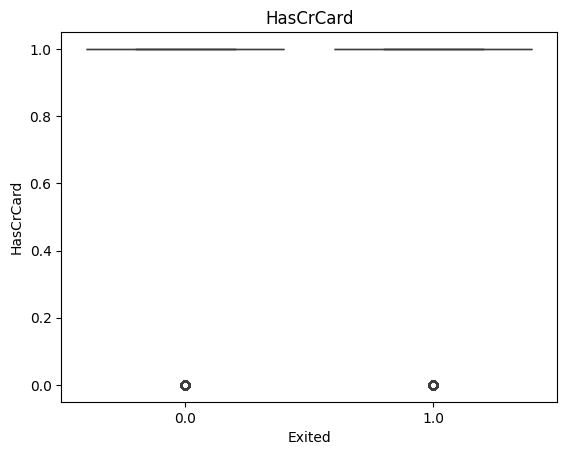

In [45]:
sns.boxplot(x="Exited", y = "HasCrCard", data=train_selection)
plt.title('HasCrCard')

In [24]:
Q1 = train_selection["CreditScore"].quantile(0.25)
Q3 = train_selection["CreditScore"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = train_selection[(train_selection["CreditScore"] < lower_bound) | (train_selection["CreditScore"] > upper_bound)]
print(f"Outliers for CreditScore:")
print(outliers[["CreditScore"]])  # Print only the specific column for clarity
print("\n" + "-" * 50 + "\n")  # Separator for readability

Outliers for CreditScore:
       CreditScore
11889       4818.0
7906         434.0
5815         438.0
8546         438.0
12255        431.0
12651        437.0
11861        431.0
12346        439.0
7756         439.0
7647         438.0
5746         439.0

--------------------------------------------------



Given that credit scores typically don't exceed 850, the value 4818 is clearly an anomaly => point abberant.

Scores in the 431–439 range are typically valid but represent very poor creditworthiness. They should usually be kept in the dataset unless there is a specific reason to filter them out.

In [25]:
# suppression des valeurs aberrantes pour CreditScore
train_selection = train_selection[train_selection['CreditScore'] <= 1000]

In [26]:
#For test set
X_test = X_test[X_test['CreditScore'] <= 1000]

In [27]:
#¨Pour set de validation
Q1 = test_selection["CreditScore"].quantile(0.25)
Q3 = test_selection["CreditScore"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = test_selection[(test_selection["CreditScore"] < lower_bound) | (test_selection["CreditScore"] > upper_bound)]
print(f"Outliers for CreditScore:")
print(outliers[["CreditScore"]])  # Print only the specific column for clarity
print("\n" + "-" * 50 + "\n")  # Separator for readability

#On voit pas de probleme ici

Outliers for CreditScore:
       CreditScore
3873         434.0
7974         447.0
12414        438.0
5833         431.0
2500         431.0
10934        446.0
8939         434.0

--------------------------------------------------



# Encoding

In [28]:
# Encodez les variables catégorielles en utilisant One-Hot Encoding
categorical_columns = [col for col in ['Geography', 'Gender'] if col in train_selection.columns]
train_selection = pd.get_dummies(train_selection, columns=categorical_columns, drop_first=True)
test_selection = pd.get_dummies(test_selection, columns=categorical_columns, drop_first=True)

binary_columns = ['Geography_Germany','Geography_Spain', 'Gender_Male']
train_selection[binary_columns] = train_selection[binary_columns].astype(int)
test_selection[binary_columns] = test_selection[binary_columns].astype(int)

In [29]:
# Encodez les variables catégorielles en utilisant One-Hot Encoding
categorical_columns = [col for col in ['Geography', 'Gender'] if col in X_test.columns]
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

X_test[binary_columns] = X_test[binary_columns].astype(int)


In [34]:
X_train = train_selection.drop(columns=['Exited'])  # Toutes les colonnes sauf 'Exited' pour les variables explicatives
y_train = train_selection['Exited']                 # Cible (1 = churn, 0 = non-churn)

X_val = test_selection.drop(columns=['Exited'])  # Toutes les colonnes sauf 'Exited' pour les variables explicatives
y_val = test_selection['Exited'] 


# Normalisation

In [35]:
from sklearn.preprocessing import RobustScaler

continuous_columns = (X_train.drop(columns=['Geography_Germany','Geography_Spain', 'Gender_Male'])).columns
binary_columns = ['Geography_Germany','Geography_Spain', 'Gender_Male']

scaler = RobustScaler()

# On applique le scaler aux colonnes continues de X_train et X_test
X_train_scaled = scaler.fit_transform(X_train[continuous_columns])
X_val_scaled = scaler.transform(X_val[continuous_columns])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=continuous_columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=continuous_columns, index=X_val.index)

# On concatène les colonnes binaires avec les colonnes continues mises à l'échelle
X_train_scaled = pd.concat([X_train_scaled, X_train[binary_columns]], axis=1)
X_val_scaled = pd.concat([X_val_scaled, X_val[binary_columns]], axis=1)


In [36]:
continuous_columns = (X_test.drop(columns=['Geography_Germany','Geography_Spain', 'Gender_Male'])).columns
binary_columns = ['Geography_Germany','Geography_Spain', 'Gender_Male']

scaler = RobustScaler()

# On applique le scaler aux colonnes continues de X_train et X_test
X_test_scaled = scaler.fit_transform(X_test[continuous_columns])

X_test_scaled = pd.DataFrame(X_test_scaled, columns=continuous_columns, index=X_test.index)

# On concatène les colonnes binaires avec les colonnes continues mises à l'échelle
X_test_scaled = pd.concat([X_test_scaled, X_test[binary_columns]], axis=1)


In [37]:
X_train_scaled.dtypes

CreditScore          float64
Age                  float64
Tenure               float64
Balance              float64
NumOfProducts        float64
HasCrCard            float64
IsActiveMember       float64
EstimatedSalary      float64
Geography_Germany      int32
Geography_Spain        int32
Gender_Male            int32
dtype: object

# Feature selection

In [38]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calcul_vif(X):
    """
    Calcul du VIF (Variance Inflation Factor) pour chaque variable dans X.
    """
    donnees_vif = pd.DataFrame()
    donnees_vif["feature"] = X.columns
    donnees_vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return donnees_vif

def calcul_correlation(X, y):
    """
    Calcul de la corrélation entre chaque variable de X et la variable cible y.
    """
    donnees_correlation = X.apply(lambda x: x.corr(y))
    donnees_correlation = donnees_correlation.reset_index()
    donnees_correlation.columns = ["feature", "correlation"]
    return donnees_correlation

def remove_highvif_lowcorrelation(X, y, seuil_vif=5):
    """
    Suppression des variables avec un VIF élevé (VIF>5) et une corrélation faible avec la cible y 
    jusqu'à ce que toutes les variables restantes aient un VIF inférieur au seuil.
    """
    # Calcul du VIF et de la corrélation
    donnees_vif = calcul_vif(X)
    donnees_correlation = calcul_correlation(X, y)
    
    # Fusionner les résultats de VIF et des corrélations
    donnees_combinees = pd.merge(donnees_vif, donnees_correlation, on="feature")

    while donnees_combinees['VIF'].max() > seuil_vif:
        # Trier par VIF élevé et corrélation faible
        donnees_combinees = donnees_combinees.sort_values(by=['VIF', 'correlation'], ascending=[False, True])
        var_a_eliminer = donnees_combinees.iloc[0]['feature']  # La variable à supprimer
        print(f"On élimine '{var_a_eliminer}' avec un VIF de: {donnees_combinees.iloc[0]['VIF']} et une corrélation de: {donnees_combinees.iloc[0]['correlation']}")
        
        # Suppression de la variable dans X
        X = X.drop(columns=[var_a_eliminer])

        # Recalculer VIF et corrélation après suppression
        donnees_vif = calcul_vif(X)
        donnees_correlation = calcul_correlation(X, y)
        donnees_combinees = pd.merge(donnees_vif, donnees_correlation, on="feature") 

    return X, donnees_combinees

X_train_scaled, vif_correlation_data = remove_highvif_lowcorrelation(X_train_scaled, y_train, seuil_vif=5)



In [39]:
X_val_scaled=X_val_scaled[X_train_scaled.columns]

In [40]:
X_train_scaled.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
13136,0.364486,0.0,0.50,0.0,0.0,-1.0,0.0,-0.900744,0,1,0
3536,0.317757,0.0,-1.00,0.0,0.0,0.0,0.0,-0.080582,0,0,1
10296,-0.532710,0.3,-0.25,0.0,0.0,0.0,1.0,-0.659766,0,0,0
2137,0.869159,0.1,0.25,0.0,0.0,0.0,1.0,-1.432202,0,0,0
14775,0.495327,-1.1,0.00,0.0,0.0,0.0,1.0,-0.471101,0,1,0


# XG boost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV
import xgboost as xgb

param_grid = {
    # General parameters
    'booster': ['gbtree', 'dart'],  # Tree-based boosters are typical for classification
    'objective': ['binary:logistic', 'multi:softmax'],  # Binary or multiclass classification
    'num_class': [3, 5, 10],  # Only for multiclass classification; adjust to your specific case

    # Booster-specific parameters
    'n_estimators': [100, 200, 500],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Learning rate (aka eta)
    'max_depth': [3, 5, 7, 10],  # Depth of trees; deeper trees are more complex
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weights in a leaf

    # Regularization parameters
    'gamma': [0, 0.1, 0.2, 0.3],  # Minimum loss reduction required for a split
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used per tree
    'colsample_bytree': [0.5, 0.7, 1.0],  # Fraction of features used per tree
    'lambda': [1, 1.5, 2],  # L2 regularization term
    'alpha': [0, 0.5, 1],  # L1 regularization term

    # Dart-specific parameters
    'sample_type': ['uniform', 'weighted'],  # Only relevant if booster='dart'
    'normalize_type': ['tree', 'forest'],  # Only relevant if booster='dart'
    'rate_drop': [0.0, 0.1, 0.2],  # Only relevant if booster='dart'
    'skip_drop': [0.0, 0.1, 0.2],  # Only relevant if booster='dart'

    # Imbalanced data handling
    'scale_pos_weight': [1, 5, 10],  # Useful for imbalanced classes in binary classification
    
    # Additional settings
    'tree_method': ['auto', 'hist', 'gpu_hist'],  # 'hist' and 'gpu_hist' are efficient for larger datasets
    'seed': [42]  # Fixed random seed for reproducibility
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = xgb.XGBClassifier(eval_metric='auc', use_label_encoder=False)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=20, scoring='roc_auc', cv=cv, random_state=42, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)

best_model = random_search.best_estimator_
y_pred_proba_best = best_model.predict_proba(X_val_scaled)[:, 1]
auc_best = roc_auc_score(y_val, y_pred_proba_best)
print("Best AUC after hyperparameter tuning:", auc_best)


In [ ]:
y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

# Créez sample_submission avec 'id' et 'Churn_Probability'
sample_submission_test_N = data_test[['id']].copy()  # Copie uniquement la colonne 'id' de data_test
sample_submission_test_N["Exited"] = y_pred_proba_best  # Ajout des probabilités de churn

# Optionnel : Exportez sample_submission en CSV
sample_submission_test_N.to_csv("sample_submission_test_N.csv", index=False)


Partie Samanta

In [47]:
# Importations nécessaires
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
# Sélection des hyper-paramètres du Grid Search
params_grid = {
    'learning_rate': [0.01, 0.05],
    'gamma':[0, 0.01],
    'max_depth': [6, 7],
    'min_child_weight': [1, 2],
    'subsample': [0.6, 0.7,],
    'n_estimators': [400, 600],
    'colsample_bytree':[0.7, 0.8],
}

stratified_kfold = StratifiedKFold(n_splits=4)

classifier = XGBClassifier()

grid_classifier = GridSearchCV(
    estimator=classifier,
    param_grid=params_grid,
    scoring='roc_auc',
    cv=stratified_kfold # Utilisation du Stratified K-Fold comme méthode de Cross Validation
    # Afin de s'assurer que chaque segment créée dispose bien des mêmes proportions de
    # la variable cible.
)
grid_classifier.fit(X_train_scaled, y_train)

c:\Users\lamou\Downloads\M2_MOSEF_S1\Data Mining\Projet_challenge\.venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.7, 0.8], 'gamma': [0, 0.01],
                         'learning_rate': [0.01, 0.05], 'max_depth': [6, 7],
                         'min_child_weight': [1, 2], 'n_estimators': [400, 600],
                         'subsample': [0.6, 0.7]},
             scoring='roc_auc')

In [48]:
# On récupère les meilleurs hyper-paramètres du modèle
best_parameters = grid_classifier.best_params_
best_parameters

{'colsample_bytree': 0.7,
 'gamma': 0.01,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 400,
 'subsample': 0.7}

In [49]:
# Récupération du meilleur modèle entraîné
best_xgb_model = grid_classifier.best_estimator_


In [50]:
# Prédiction des probabilités sur l'ensemble de validation ou de test
y_val_pred_proba = best_xgb_model.predict_proba(X_val_scaled)[:, 1]  # Probabilités pour la classe positive

# Calcul de l'AUC-ROC pour évaluer la performance sur l'ensemble de validation
roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print("ROC AUC Score on Validation Set:", roc_auc)


ROC AUC Score on Validation Set: 0.9386929682822859
